# Parameters

In [0]:
source_folder = '/content/drive/My Drive/COMP_4211_Project/Data/Phase_3'
destination_folder = '/content/drive/My Drive/COMP_4211_Project/Models/Phase_3'

# Libraries

In [4]:
!pip install sacremoses

     |████████████████████████████████| 890kB 4.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=37204c00eebb0b4f6406a28ed8592751b78b5224c665194ff8d0a875fd9daa16
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [0]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='moses', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset

train, valid = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                     format='CSV', fields=fields, skip_header=True)
UV_train, UV_test = TabularDataset.splits(path=source_folder, train='UVictoria_train.csv', test='UVictoria_test.csv',
                                     format='CSV', fields=fields, skip_header=True)
LIAR_train, LIAR_valid, LIAR_test = TabularDataset.splits(path=source_folder,
                                                          train='LIAR_train.csv', validation='LIAR_valid.csv', test='LIAR_test.csv',
                                                          format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
UV_train_iter = BucketIterator(UV_train, batch_size=32, sort_key=lambda x: len(x.text),
                               device=device, sort=True, sort_within_batch=True)
UV_test_iter = BucketIterator(UV_test, batch_size=32, sort_key=lambda x: len(x.text),
                              device=device, sort=True, sort_within_batch=True)
LIAR_train_iter = BucketIterator(LIAR_train, batch_size=32, sort_key=lambda x: len(x.text),
                                 device=device, sort=True, sort_within_batch=True)
LIAR_valid_iter = BucketIterator(LIAR_valid, batch_size=32, sort_key=lambda x: len(x.text),
                                 device=device, sort=True, sort_within_batch=True)
LIAR_test_iter = BucketIterator(LIAR_test, batch_size=32, sort_key=lambda x: len(x.text),
                                device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

# Models

In [0]:
class OurEncoder(nn.Module):
    
    def __init__(self, dimension):
        super(OurEncoder, self).__init__()
        
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, text_emb, text_len):
        
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)

        return self.drop(out_reduced)

In [0]:
class OurClassifier(nn.Module):

    def __init__(self, dimension):
        super(OurClassifier, self).__init__()

        self.fc = nn.Linear(dimension, 1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.squeeze(x, 1)
        x = torch.sigmoid(x)

        return x

In [0]:
class WORD2VEC(nn.Module):

    def __init__(self, dimension=128):
        super(WORD2VEC, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.encoder = OurEncoder(dimension)
        self.classifier = OurClassifier(2*dimension)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        text_fea = self.encoder(text_emb, text_len)
        text_out = self.classifier(text_fea)

        return text_out

# Pretraining

In [0]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [0]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf"),
          version = 'default'):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            
            output = model(text, text_len)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, (text, text_len)), _ in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        text_len = text_len.to(device)
                        
                        output = model(text, text_len)
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + version + '_model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [60]:
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='Word2Vec')

Epoch [1/5], Step [79/790], Train Loss: 0.6026, Valid Loss: 0.3986
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_metrics.pt
Epoch [1/5], Step [158/790], Train Loss: 0.4197, Valid Loss: 0.3169
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_metrics.pt
Epoch [2/5], Step [237/790], Train Loss: 0.2458, Valid Loss: 0.2496
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_metrics.pt
Epoch [2/5], Step [316/790], Train Loss: 0.2121, Valid Loss: 0.2151
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Mode

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_metrics.pt


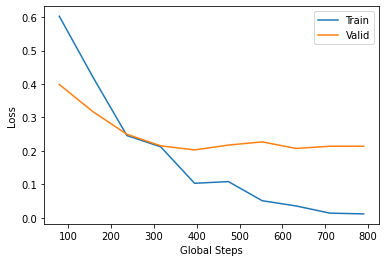

In [61]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/Word2Vec_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Training and Evaluation

In [0]:
# Evaluation Function

def evaluate(model, test_loader, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            
            output = model(text, text_len)
            output = (output > threshold).int()
            
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

## ISOT News Dataset

In [63]:
# Training Without Pretraining
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='Word2Vec_Trained',
      train_loader = UV_train_iter, valid_loader = UV_train_iter,
      eval_every=len(UV_train_iter))

Epoch [1/5], Step [28/140], Train Loss: 0.4261, Valid Loss: 0.2223
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_metrics.pt
Epoch [2/5], Step [56/140], Train Loss: 0.1760, Valid Loss: 0.1086
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_metrics.pt
Epoch [3/5], Step [84/140], Train Loss: 0.0759, Valid Loss: 0.0340
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_metrics.pt
Epoch [4/5], Step [112/140], Train Loss: 0.0274, Valid Loss: 0.0164
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_model.pt
Model saved

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9857    0.9114    0.9471     22290
           0     0.9129    0.9859    0.9480     20988

    accuracy                         0.9475     43278
   macro avg     0.9493    0.9487    0.9475     43278
weighted avg     0.9504    0.9475    0.9475     43278



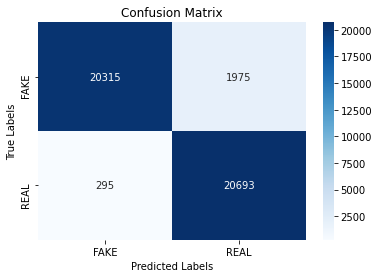

In [64]:
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_Trained_model.pt', model, optimizer)

evaluate(model, UV_test_iter)

In [65]:
# Training With Pretraining
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_model.pt', model, optimizer)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='Word2Vec_TrainedPretrained',
      train_loader = UV_train_iter, valid_loader = UV_train_iter,
      eval_every=len(UV_train_iter))

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Epoch [1/5], Step [28/140], Train Loss: 0.3009, Valid Loss: 0.1258
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_metrics.pt
Epoch [2/5], Step [56/140], Train Loss: 0.0984, Valid Loss: 0.0443
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_metrics.pt
Epoch [3/5], Step [84/140], Train Loss: 0.0453, Valid Loss: 0.0226
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_metrics.pt
Epoch [4/5], Step [112/1

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9684    0.9513    0.9597     22290
           0     0.9492    0.9670    0.9580     20988

    accuracy                         0.9589     43278
   macro avg     0.9588    0.9591    0.9589     43278
weighted avg     0.9591    0.9589    0.9589     43278



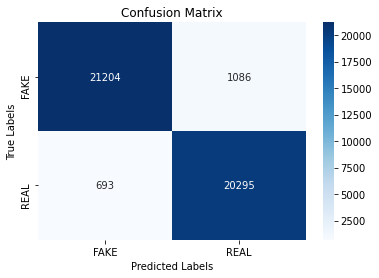

In [66]:
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_TrainedPretrained_model.pt', model, optimizer)

evaluate(model, UV_test_iter)

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8364    0.5682    0.6767     22290
           0     0.6579    0.8819    0.7536     20988

    accuracy                         0.7204     43278
   macro avg     0.7471    0.7251    0.7152     43278
weighted avg     0.7498    0.7204    0.7140     43278



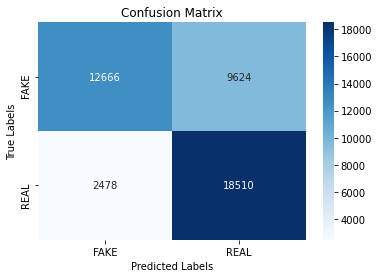

In [67]:
# Without Training
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_model.pt', model, optimizer)

evaluate(model, UV_test_iter)

## LIAR Dataset

In [117]:
# Training Without Pretraining
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='Word2Vec_Trained_2',
      train_loader = LIAR_train_iter, valid_loader = LIAR_valid_iter,
      eval_every=len(LIAR_train_iter)//2)

Epoch [1/5], Step [91/910], Train Loss: 0.6879, Valid Loss: 0.6678
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_2_metrics.pt
Epoch [1/5], Step [182/910], Train Loss: 0.6756, Valid Loss: 0.6588
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_2_metrics.pt
Epoch [2/5], Step [273/910], Train Loss: 0.6234, Valid Loss: 0.6514
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_2_metrics.pt
Epoch [2/5], Step [364/910], Train Loss: 0.6188, Valid Loss: 0.6643
Epoch [3/5], Step [455/910], Train Loss: 0.5222, Valid Loss: 0.6792
Epoch [3/5], Step [546/910], Tr

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_Trained_2_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.5993    0.4916    0.5401       356
           0     0.6485    0.7406    0.6915       451

    accuracy                         0.6307       807
   macro avg     0.6239    0.6161    0.6158       807
weighted avg     0.6268    0.6307    0.6247       807



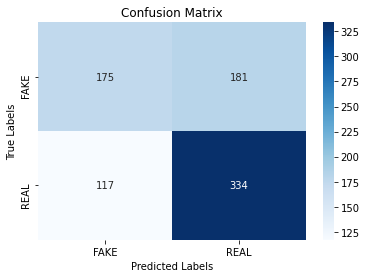

In [118]:
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_Trained_2_model.pt', model, optimizer)

evaluate(model, LIAR_test_iter)

In [119]:
# Training With Pretraining
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_model.pt', model, optimizer)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='Word2Vec_TrainedPretrained_2',
      train_loader = LIAR_train_iter, valid_loader = LIAR_valid_iter,
      eval_every=len(LIAR_train_iter)//2)

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Epoch [1/5], Step [91/910], Train Loss: 0.7672, Valid Loss: 0.6677
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_2_metrics.pt
Epoch [1/5], Step [182/910], Train Loss: 0.6998, Valid Loss: 0.6582
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_2_metrics.pt
Epoch [2/5], Step [273/910], Train Loss: 0.5989, Valid Loss: 0.6521
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_2_metrics.pt
Epoch [2/5

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_TrainedPretrained_2_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6093    0.5169    0.5593       356
           0     0.6594    0.7384    0.6967       451

    accuracy                         0.6406       807
   macro avg     0.6343    0.6276    0.6280       807
weighted avg     0.6373    0.6406    0.6360       807



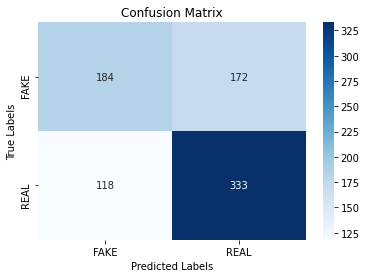

In [120]:
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_TrainedPretrained_2_model.pt', model, optimizer)

evaluate(model, LIAR_test_iter)

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/Word2Vec_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.4888    0.3062    0.3765       356
           0     0.5771    0.7472    0.6512       451

    accuracy                         0.5527       807
   macro avg     0.5329    0.5267    0.5139       807
weighted avg     0.5381    0.5527    0.5300       807



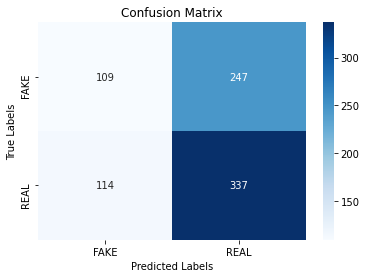

In [121]:
# Without Training
model = WORD2VEC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Word2Vec_model.pt', model, optimizer)

evaluate(model, LIAR_test_iter)